# Friends Classification Text (LSTM) - 2

This is classification of dialogue in FRIENDS TV Series.

text only :
the character scipt + "as respond to"-script

<!-- https://stackoverflow.com/questions/61000500/tensorflow-keras-bert-multiclass-text-classification-accuracy -->

In [1]:
import pandas as pd
import re
import numpy as np
import time

import os
import pprint
import tensorflow as tf

import sys
sys.path.insert(1, '../../src/all_functions/')

from text_tools import *

import keras
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.models import load_model

from keras.layers import Embedding, LSTM
import matplotlib.pyplot as plt
from keras import Sequential

from keras import backend as K
from keras import layers

from sklearn.preprocessing import OneHotEncoder


from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)

import matplotlib.pyplot as plt
import seaborn as sns


# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# help(drive.mount)

In [3]:
def encode(text):
    token_ids = []
    for word in text:
        try:
            token_ids.append(word2idx[word])
        except:
            token_ids.append(1)
            
    token_ids = np.array(token_ids)
    return token_ids

def set_fix_length(ids, max_len = 15):
    # print(ids)
    length = ids.shape[0]
    zeros = np.zeros(max_len)

    if length <= max_len:
        zeros[:length] = ids
    else:
        zeros = ids[:max_len]

    return zeros

In [4]:
# PATH_DATA = 'gdrive/'
PATH_DATA = '../../data/'

In [5]:
os.listdir(PATH_DATA)

['friends_seen_season_new.csv',
 'friends_unseen_season.csv',
 'friends-transcripts',
 'friends_all_dialogue.csv',
 '.DS_Store',
 'friends_all_dialogue_semi_cln.csv',
 'friends_unseen_season2_2.csv',
 'friends_unseen_season_1.csv',
 'friends_seen_season2_2.csv',
 'friends-transcripts-extract',
 'friends_seen_season2_new.csv',
 'friends_unseen_season_new.csv',
 'friends_seen_season.csv',
 'friends_all_dialogue_semi_cln2.csv',
 'friends_unseen_season2_new.csv',
 '.ipynb_checkpoints',
 'friends_seen_season2.csv',
 'friends_unseen_season2.csv',
 'friends_seen_season_1.csv']

## Importing Data

In [6]:
# %cd gdrive/My Drive/Repository/Data/

In [7]:
# os.listdir()

In [8]:
# df_dlg_seen = pd.read_csv(PATH_DATA+'friends_seen_season2.csv')
# df_dlg_unseen = pd.read_csv(PATH_DATA+'friends_unseen_season2.csv')

In [9]:
df_dlg_seen = pd.read_csv(PATH_DATA+'friends_seen_season2_2.csv')
df_dlg_unseen = pd.read_csv(PATH_DATA+'friends_unseen_season2_2.csv')

/Users/alamhanz/anaconda/envs/joko/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
data_train = df_dlg_seen[(df_dlg_seen.is_train == True)&(df_dlg_seen.label!=0)][['text1','text2','label']]
data_train['label'] = data_train['label']-1
data_train = data_train[~(data_train.text1.isnull())]

data_test = df_dlg_seen[(df_dlg_seen.is_train == False)&(df_dlg_seen.label!=0)][['text1','text2','label']]
data_test['label'] = data_test['label']-1
data_test = data_test[~(data_test.text1.isnull())]

data_unseen = df_dlg_unseen[(df_dlg_unseen.label!=0)][['text1','text2','label']]
data_unseen['label'] = data_unseen['label']-1
data_unseen = data_unseen[~(data_unseen.text1.isnull())]

In [11]:
data_train.shape

(25981, 3)

In [12]:
data_test.shape

(8593, 3)

In [13]:
data_unseen.shape

(8305, 3)

In [14]:
XX = data_test.label.value_counts()
XX/XX.sum()

1    0.178867
0    0.177470
3    0.167811
2    0.167229
4    0.160014
5    0.148609
Name: label, dtype: float64

## Tokenizer

In [15]:
MAX_LEN = 20
EMBED_SIZE = 128

In [16]:
OH = OneHotEncoder()

In [17]:
data_train.head()

,text1,text2,label
1,c'mon you're going out with the guy there's go...,all right joey be nice so does he have a hump ...,3
3,just because i don't want her to go through wh...,okay everybody relax this is not even a date i...,2
4,okay everybody relax this is not even a date i...,sounds like a date to me,3
7,then i look down and i realize there's a phone...,instead of,4
9,that's,never had that dream,4


In [18]:
data_test.head()

,text1,text2,label
0,there's nothing to tell he's just some guy i w...,c'mon you're going out with the guy there's go...,4
2,all right joey be nice so does he have a hump ...,wait does he eat chalk,5
6,oh yeah had that dream,then i look down and i realize there's a phone...,3
8,instead of,that's,3
11,no,all of a sudden the phone starts to ring now i...,3


In [19]:
data_unseen.head()

,text1,text2,label
0,so uh i guess we should make it official huh,uh look rach hey ross is here hey look it's my...,4
1,uh look rach hey ross is here hey look it's my...,joey you,1
2,joey you,you,0
3,you,hey and look he brought flowers thanks ross bu...,4
4,hey and look he brought flowers thanks ross bu...,you're weird today listen i uh wanted to talk ...,1


In [20]:
get_ids = pd.concat([data_train,data_test])
get_ids = pd.DataFrame(get_ids['text1'].tolist()+get_ids['text2'].tolist(),columns = ['text'])

In [21]:
word2idx, idx2word = data_text_prep(get_ids)

In [22]:
VOCAB_SIZE = len(word2idx)
VOCAB_SIZE

13352

In [23]:
def get_input(df):
    X1 = []
    X2 = []
    label_ls = []
    for txt1,txt2,label in df.values:
        text_encode = encode(txt1)
        text_encode = set_fix_length(text_encode,max_len=MAX_LEN)
        X1.append(text_encode)
        
        text_encode = encode(txt2)
        text_encode = set_fix_length(text_encode,max_len=MAX_LEN)
        X2.append(text_encode)
        
        label_ls.append(label)
    return np.stack(X1),np.stack(X2),np.array(label_ls)

In [24]:
X_train1,X_train2,label_train = get_input(data_train)
X_test1,X_test2,label_test = get_input(data_test)
X_unseen1,X_unseen2,label_unseen = get_input(data_unseen)

In [25]:
OH.fit(label_train.reshape(len(label_train),-1))

OneHotEncoder()

In [26]:
y_train = OH.transform(label_train.reshape(len(label_train),-1)).toarray()
y_test = OH.transform(label_test.reshape(len(label_test),-1)).toarray()
y_unseen = OH.transform(label_unseen.reshape(len(label_unseen),-1)).toarray()

## Training Model

In [27]:
def text_net() :
    # sentence_indices = keras.Input(25, dtype = 'int32')
    mod1 = Sequential()
    mod1.add(Embedding(VOCAB_SIZE, EMBED_SIZE))
    mod1.add(LSTM(128,return_sequences = True))
    mod1.add(LSTM(64,return_sequences = True))
    mod1.add(layers.Dropout(0.4))
    return mod1

In [28]:
input_dim_txt = (MAX_LEN)
txt_1 = keras.Input(shape=input_dim_txt)
txt_2 = keras.Input(shape=input_dim_txt)

In [29]:
tx_net = text_net()
connect_layer = layers.Concatenate(axis=2)

feat_txt_1 = tx_net(txt_1)
feat_txt_2 = tx_net(txt_2)

concat_txt = connect_layer([feat_txt_1, feat_txt_2])


LSTM_2 = LSTM(32,return_sequences = True)(concat_txt)
layers_n = layers.Flatten()(LSTM_2)
layers_n = layers.Dense(256,activation='relu')(layers_n)
layers_n = layers.Dropout(0.4)(layers_n)
layers_n = layers.Dense(64,activation='relu')(layers_n)
layers_n = layers.Dropout(0.3)(layers_n)
layers_n = layers.Dense(16,activation='relu')(layers_n)
layers_n = layers.Dropout(0.2)(layers_n)
prediction = layers.Dense(6,activation='softmax')(layers_n)

mod1 = keras.Model(inputs = [txt_1, txt_2], outputs = prediction)

In [30]:
mod1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, 64)     1890048     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 20, 128)      0           sequential[0][0]      

In [31]:
# keras.utils.plot_model(mod1)

In [32]:
filepath = '../../models/simple_LSTM2/model_{epoch:02d}_{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

In [33]:
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
LR = 5e-4
EPOCHS = 40
BATCH_SIZE = 20
opt = keras.optimizers.Adam(learning_rate=LR)
mod1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

mod_history = mod1.fit([X_train1,X_train2], y_train, 
            validation_data=([X_test1,X_test2], y_test), 
            epochs=EPOCHS, batch_size = BATCH_SIZE, verbose=1,
            callbacks=[checkpoint])

Epoch 1/40
1300/1300 [==============================] - ETA: 0s - loss: 1.7887 - accuracy: 0.1811
Epoch 00001: val_accuracy improved from -inf to 0.18573, saving model to ../../models/simple_LSTM2/model_01_0.19.hdf5
1300/1300 [==============================] - 172s 132ms/step - loss: 1.7887 - accuracy: 0.1811 - val_loss: 1.7809 - val_accuracy: 0.1857
Epoch 2/40
1300/1300 [==============================] - ETA: 0s - loss: 1.7791 - accuracy: 0.1923
Epoch 00002: val_accuracy improved from 0.18573 to 0.19062, saving model to ../../models/simple_LSTM2/model_02_0.19.hdf5
1300/1300 [==============================] - 148s 114ms/step - loss: 1.7791 - accuracy: 0.1923 - val_loss: 1.7722 - val_accuracy: 0.1906
Epoch 3/40
1300/1300 [==============================] - ETA: 0s - loss: 1.7713 - accuracy: 0.2038
Epoch 00003: val_accuracy improved from 0.19062 to 0.19888, saving model to ../../models/simple_LSTM2/model_03_0.20.hdf5
1300/1300 [==============================] - 148s 114ms/step - loss: 1.7

## Testing

In [34]:
mod_use = keras.models.load_model('../../models/simple_LSTM2/model_21_0.29.hdf5')

In [35]:
def plot_cm(labels, predictions, type_eval = 'test'):
    cm = confusion_matrix(labels, predictions)
    cm = (cm.transpose()/cm.sum(axis = 1)).transpose()
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt=".2%")
    plt.title("Confusion matrix ("+type_eval+") - 2")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")

In [36]:
y_pred_test = mod_use.predict([X_test1,X_test2])
y_pred_test = np.argmax(y_pred_test,axis = 1)
y_true_test = np.argmax(y_test,axis = 1)

              precision    recall  f1-score   support

           0       0.28      0.48      0.35      1525
           1       0.29      0.31      0.30      1537
           2       0.25      0.37      0.29      1437
           3       0.28      0.15      0.20      1442
           4       0.34      0.24      0.28      1375
           5       0.41      0.14      0.20      1277

    accuracy                           0.29      8593
   macro avg       0.31      0.28      0.27      8593
weighted avg       0.30      0.29      0.27      8593



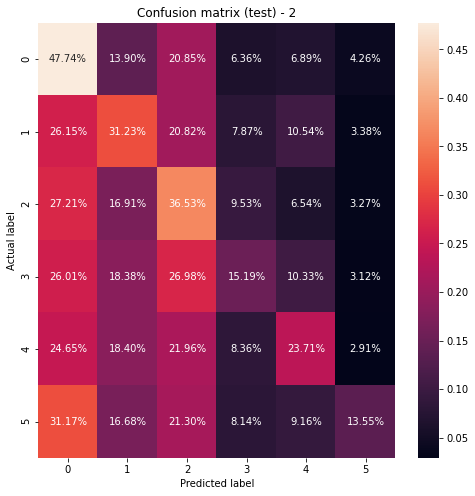

In [37]:
report = classification_report(y_true_test,y_pred_test)
print(report)
plot_cm(y_true_test,y_pred_test, type_eval = 'test')

In [38]:
y_pred = mod_use.predict([X_unseen1,X_unseen2])
y_pred_label = np.argmax(y_pred,axis = 1)
y_true_label = data_unseen['label'].values

              precision    recall  f1-score   support

           0       0.24      0.43      0.31      1410
           1       0.26      0.28      0.27      1497
           2       0.21      0.33      0.26      1369
           3       0.28      0.15      0.20      1401
           4       0.33      0.22      0.26      1360
           5       0.36      0.11      0.16      1268

    accuracy                           0.26      8305
   macro avg       0.28      0.25      0.24      8305
weighted avg       0.28      0.26      0.24      8305



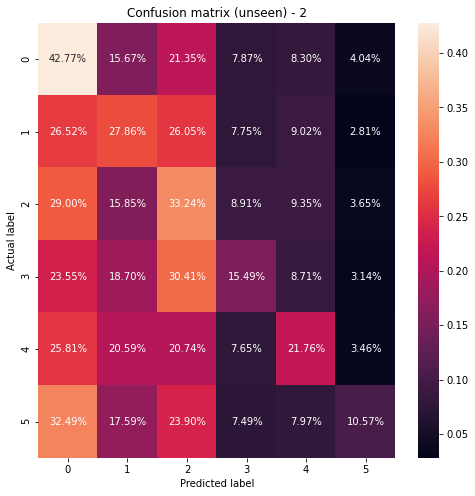

In [39]:
report = classification_report(y_true_label, y_pred_label)
print(report)
plot_cm(y_true_label, y_pred_label,type_eval = 'unseen')